You may have seen [my previous post](https://dashee87.github.io/deep%20learning/python/predicting-cryptocurrency-prices-with-deep-learning/) that tried to predict bitcoin and ethereum prices with deep learning. To summarise, there was alot of hype but it wasn't very useful in practice (I'm referring to the model, of course). To improve the model, we have two options: carefully design an intricately more sophisticated model (i.e. [throw shit tons more layers in there](https://dashee87.github.io/data%20science/deep%20learning/python/another-keras-tutorial-for-neural-network-beginners/)) or identify more informative data sources that can be fed into the model. While it's tempting to focus on the former, the garbage-in-garbage-out principle remains. 

With that in mind, I created a new Python package called [cryptory](https://github.com/dashee87/cryptory). Not to be confused with the [obscure Go repo](https://github.com/mtamer/cryptory) (damn you, mtamer) or [that bitcoin scam](https://www.reddit.com/r/Scams/comments/2ao4aw/cryptorycom_scam_alert_stay_away/?st=jd3c7q9a&sh=9af44946) (you try to come up with a crypto package name that isn't associated with some scam), it integrates various packages and protocols so that you can get historical crypto (just daily... for now) and wider economic/social data in one place. Rather than making more crypto based jokes, I should probably just explain the package.

As always, the full code for this post can found on my [GitHub account](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2018-02-11-analysing-the-factors-that-influence-cryptocurrency-prices-with-cryptory.ipynb).

## Installation

`cryptory` is available on [PyPi](https://pypi.python.org/pypi/cryptory/0.1.0) and [GitHub](https://github.com/dashee87/cryptory), so installing it is as easy as running `pip install cryptory` in your command line/shell.

![](https://github.com/dashee87/dashee87.github.io/raw/master/images/install_cryptory.png)

It relies on pandas, numpy, BeautifulSoup and [pytrends](https://github.com/GeneralMills/pytrends), but, if necesssary, these packages should be automatically installed alongisde cryptory.

The next step is to load the package into the working environment. Specifically, we'll import the `Cryptory` class.

In [1]:
# import package
from cryptory import Cryptory

Assuming that returned no errors, you're now ready to starting pulling some data. But before we do that, it's worth mentioning that you can retrieve information about each method by running the `help` function.

In [2]:
help(Cryptory)

Help on class Cryptory in module cryptory.cryptory:

class Cryptory
 |  Methods defined here:
 |  
 |  __init__(self, from_date, to_date=None, ascending=False, fillgaps=True, timeout=10.0)
 |      Initialise cryptory class
 |      
 |      Parameters
 |      ----------
 |      from_date : the starting date (as string) for the returned data;
 |          required format is %Y-%m-%d (e.g. "2017-06-21")
 |      to_date : the end date (as string) for the returned data;
 |          required format is %Y-%m-%d (e.g. "2017-06-21")
 |          Optional. If unspecified, it will default to the current day
 |      to_date : binary. Determines whether the returned dataframes are
 |          ordered by date in ascending or descending order 
 |          (defaults to False i.e. most recent first)
 |      fillgaps : binary. When data does not exist (e.g. weekends for stocks)
 |          should the rows be filled in with the previous available data
 |          (defaults to True e.g. Saturday stock price

We'll now create our own cryptory object, which we'll call `my_cryptory`. You need to define the start date of the data you want to retrieve, while there's also some optional arguments. For example, you can set the end date, otherwise it defaults to the current date- see `help(Cryptory.__init__)` for more information).

In [82]:
# initialise object
my_cryptory = Cryptory(from_date="2017-01-01")

### Cryptocurrency Prices

We'll start by getting some historical bitcoin prices (starting from 1st Jan 2017). `cryptory` has a few options for this type of data, which I will now demonstrate.

In [83]:
# for readability, reduce number of rows shown by default
import pandas as pd

pd.options.display.max_rows = 6

In [84]:
# get prices from coinmarketcap
my_cryptory.extract_coinmarketcap("bitcoin")

,date,open,high,low,close,volume,market cap
0,2018-02-10,8720.08,9122.55,8295.47,8621.90,7780960000,146981000000
1,2018-02-09,8271.84,8736.98,7884.71,8736.98,6784820000,139412000000
2,2018-02-08,7637.86,8558.77,7637.86,8265.59,9346750000,128714000000
...,...,...,...,...,...,...,...
403,2017-01-03,1021.60,1044.08,1021.60,1043.84,185168000,16426600000
404,2017-01-02,998.62,1031.39,996.70,1021.75,222185000,16055100000
405,2017-01-01,963.66,1003.08,958.70,998.33,147775000,15491200000


In [85]:
# get prices from bitinfocharts
my_cryptory.extract_bitinfocharts("btc")

,date,btc_price
0,2018-02-10,8691.000
1,2018-02-09,8300.000
2,2018-02-08,8256.000
...,...,...
403,2017-01-03,1017.000
404,2017-01-02,1010.000
405,2017-01-01,970.988


Those cells illustrate how to pull bitcoin prices from coinmarketcap and bitinfocharts. The discrepancy in prices returned by each can be explained by their different approaches to calculate daily prices (e.g. bitinfocharts represents the average prices across that day). For that reason, I wouldn't recommend combining different price sources.

You also pull non-price specific data with `extract_bitinfocharts` e.g. transactions fees. See `help(Cryptory.extract_bitinfocharts)` for more information.

In [87]:
# average daily eth transaction fee
my_cryptory.extract_bitinfocharts("eth", metric='transactionfees')

,date,eth_transactionfees
0,2018-02-10,0.78300
1,2018-02-09,0.74000
2,2018-02-08,0.78300
...,...,...
403,2017-01-03,0.00773
404,2017-01-02,0.00580
405,2017-01-01,0.00537


You may have noticed that each method returns a pandas dataframe. In fact, all `cryptory` methods return a pandas dataframe. This is convenient, as it allows you to slice and dice the output using common pandas techniques. For example, we can easily merge two `extract_bitinfocharts` calls to combine daily bitcoin and ethereum prices.

In [88]:
my_cryptory.extract_bitinfocharts("btc").merge(
my_cryptory.extract_bitinfocharts("eth"), on='date', how='inner')

,date,btc_price,eth_price
0,2018-02-10,8691.000,871.238
1,2018-02-09,8300.000,832.564
2,2018-02-08,8256.000,814.922
...,...,...,...
403,2017-01-03,1017.000,8.811
404,2017-01-02,1010.000,8.182
405,2017-01-01,970.988,8.233


One further source of crypto prices is offered by `extract_poloniex`, which pulls data from the [public poloniex API](https://poloniex.com/support/api/). For example, we can retrieve the BTC/ETH exchange rate.

In [89]:
# btc/eth price
my_cryptory.extract_poloniex(coin1="btc", coin2="eth")

,date,close,open,high,low,weightedAverage,quoteVolume,volume
0,2018-02-10,0.099700,0.100961,0.101308,0.098791,0.100194,2.160824e+04,2165.006520
1,2018-02-09,0.101173,0.098898,0.101603,0.098682,0.100488,2.393343e+04,2405.019824
2,2018-02-08,0.098896,0.099224,0.101196,0.096295,0.098194,2.250954e+04,2210.293015
...,...,...,...,...,...,...,...,...
403,2017-01-03,0.009280,0.008218,0.009750,0.008033,0.009084,1.376059e+06,12499.794908
404,2017-01-02,0.008220,0.008199,0.008434,0.007823,0.008101,6.372636e+05,5162.784640
405,2017-01-01,0.008200,0.008335,0.008931,0.008001,0.008471,7.046517e+05,5968.975870


We're now in a position to perform some basic analysis of cryptocurrencies prices.

In [90]:
all_coins_df = my_cryptory.extract_bitinfocharts("btc")
bitinfocoins = ['btc', 'eth', 'xrp', 'bch', 'ltc', 'dash', 'xmr', 'etc', 'zec', 
                        'doge', 'rdd', 'vtc', 'ftc', 'nmc', 'blk', 'aur', 'nvc', 'qrk']
for coin in bitinfocoins[1:]:
    all_coins_df = all_coins_df.merge(my_cryptory.extract_bitinfocharts(coin), on="date", how="left")

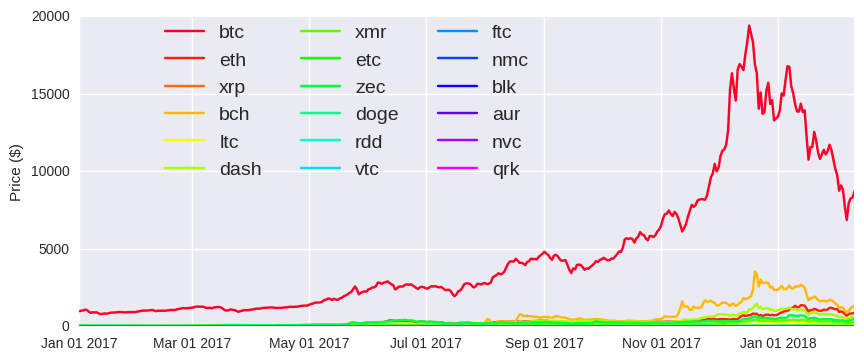

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))

cm = plt.get_cmap('gist_rainbow')

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017, 2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') for i in range(1,13,2) for j in range(2017, 2019)])
for coin,color in zip(bitinfocoins, [cm(1.*i/len(bitinfocoins)) for i in range(len(bitinfocoins))]):
    ax1.plot(all_coins_df['date'].astype(datetime.datetime), 
             all_coins_df[coin+'_price'], label=coin, color=color)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., ncol=3, prop={'size': 14})
ax1.set_ylabel('Price ($)')
plt.show()

Of course, that graph is meaningless. You can't just compare the price for single units of each coin. You need to consider the total supply and the market cap. It's like saying the dollar is undervalued compared to the Japanese Yen. But I probably shouldn't worry. It's not as if people are [buying cryptos based on them being superficially cheap](https://www.youtube.com/watch?v=SvMF10ZXVoQ). More relevant here is the relative change in price since the start of 2017, which we can plot quite easily with a little pandas magic ([pct_change](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.pct_change.html)).

In [92]:
# replace all columns (excet date) with percentage change
all_coins_df.iloc[:,1:] = all_coins_df.iloc[:,1:].divide(all_coins_df.iloc[-5:,1:].mean(), axis=1)

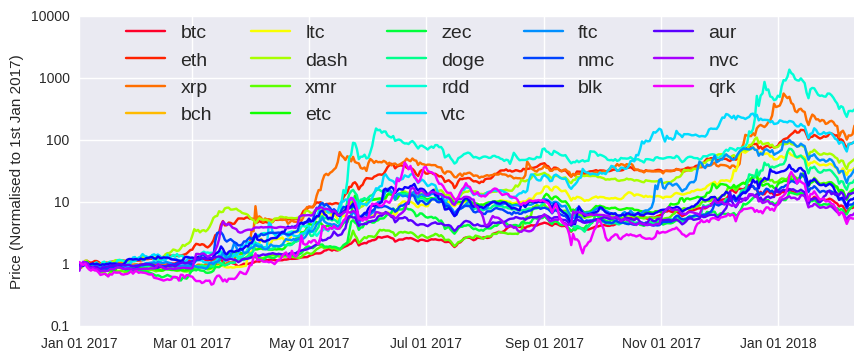

In [94]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
import numpy as np

fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))

cm = plt.get_cmap('gist_rainbow')

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017, 2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') for i in range(1,13,2) for j in range(2017, 2019)])
for coin,color in zip(bitinfocoins, [cm(1.*i/len(bitinfocoins)) for i in range(len(bitinfocoins))]):
    ax1.plot(all_coins_df['date'].astype(datetime.datetime), 
             all_coins_df[coin+'_price'].replace(to_replace=0, method='ffill'), 
             label=coin, color=color)
ax1.set_yscale('log')
# via https://stackoverflow.com/questions/21920233/matplotlib-log-scale-tick-label-number-formatting
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: (
            '{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.legend(bbox_to_anchor=(0.05, 1), loc=2, borderaxespad=0., ncol=5, prop={'size': 14})
ax1.set_ylabel('Price (Normalised to 1st Jan 2017)')
plt.show()

Those coins are provided on [bitinfocharts](https://bitinfocharts.com/comparison/bitcoin-price.html) and they tend to represent older legacy coins. For example, the coin from this list that performed best over 2017 was Reddcoin. It started 2017 with a market cap of less than 1 million dollars, but finished it with a value of around $250m, reaching a peak of over 750m in early Jan 2018. You'll notice that each coin shows the same general behaviour- a sustained rise between March and June, followed by another spike in December and a noticeable sell-off in Jan 2018. 

With a little help from pandas, we can produce a crypto price correlation plot (use the dropdown menu to switch between [Pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and [Spearman](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) correlation).

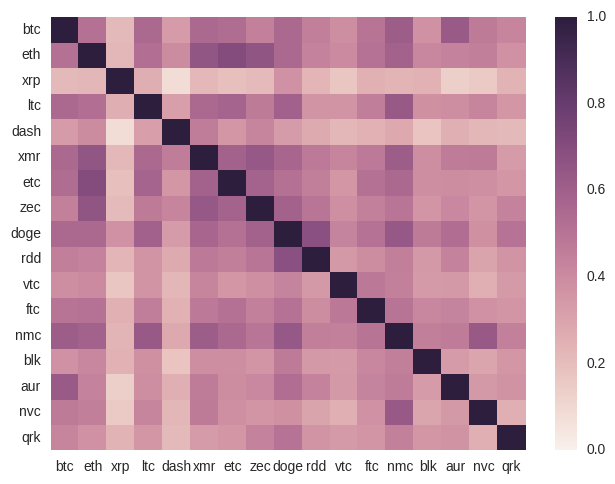

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = all_coins_df.iloc[:,1:].pct_change().corr(method='pearson')
corr = corr.dropna(axis=0, how='all').dropna(axis=1, how='all')
plt.figure(figsize=(6.7, 5))
sns.heatmap(corr, 
            xticklabels=[col.replace("_price", "") for col in corr.columns.values],
            yticklabels=[col.replace("_price", "") for col in corr.columns.values],
            vmin=0, vmax=1)
plt.tight_layout()
plt.show()

There's nothing too surprising ([or novel](https://blog.patricktriest.com/analyzing-cryptocurrencies-python/)) here. It's well known that cryptos are heavily correlated- they tend to [spike](https://imgur.com/a/UBQaw#KLDWEIG) and [crash](https://www.reddit.com/r/CryptoCurrency/comments/7it7zi/93_of_the_top_100_cryptos_are_down_today_most_of/?st=jd5sd4p0&sh=cea8d0f0) collectively. There's a few reasons for this: Most importantly, the vast majority of coins can only be exchanged with the few big coins (e.g. btc and eth). As they are priced relative to these big coins, a change in btc or eth will also change the value of those smaller coins. Secondly, it's not like the stock market. Ethereum and Bitcoin are not as different as, say, Facebook and General Motors. While stock prices are linked to hitting financial targets (i.e. quarterly earnings reports) and wider macroeconomic factors, most cryptos (maybe all) are currently powered by hope and aspirations (well, hype and speculation) around blockchain technology. That's not to say coins can't occasionally buck the market e.g. ripple (xrp) in early December. However, overperformance is often followed by market underperformance (e.g. ripple in January 2018).

I'll admit nothing I've presented so far is particularly ground breaking. You could get similar data from the [Quandl api](https://www.quandl.com/tools/python) (aside: I intend to integrate quandl API calls into `cryptory`). The real benefit of `cryptory` comes when you want to combine crypto prices with other data sources.

### Reddit Metrics

If you're familiar with cryptos, you're very likely to be aware of their associated reddit pages. It's where crypto investors come to discuss the merits of different blockchain implementations, dissect the day's main talking points and post amusing gifs- okay, [it's mostly just GIFs](https://www.reddit.com/r/Bitcoin/comments/7v438b/the_last_3_months_in_47_seconds/). With `cryptory` you can combine reddit metrics (total number of subscribers, new subscribers, rank -literally scraped from the [redditmetrics website](http://redditmetrics.com/)) and other crypto data.

Let's take a look at iota and eos; two coins that emerged in June 2017 and experienced strong growth towards the end of 2017. Their corresponding subreddits are [r/iota](https://www.reddit.com/r/Iota/) and [r/eos](https://www.reddit.com/r/eos/), respectively.

In [96]:
my_cryptory.extract_reddit_metrics("iota", "subscriber-growth")

,date,subscriber_growth
0,2018-02-10,150
1,2018-02-09,161
2,2018-02-08,127
...,...,...
404,2017-01-03,0
405,2017-01-02,0
406,2017-01-01,0


In [97]:
my_cryptory.extract_reddit_metrics("eos", "subscriber-growth")

,date,subscriber_growth
0,2018-02-10,92
1,2018-02-09,78
2,2018-02-08,100
...,...,...
405,2017-01-03,0
406,2017-01-02,0
407,2017-01-01,0


Now we can investigate the relationship between price and subreddit growth.

In [98]:
iota_df = my_cryptory.extract_reddit_metrics("iota", "subscriber-growth").merge(
my_cryptory.extract_coinmarketcap("iota"), on="date", how="inner")

iota_df = iota_df[['date', 'subscriber_growth', 'close']]
iota_df[['subscriber_growth', 'close']] = (
    iota_df[['subscriber_growth', 'close']]-iota_df[['subscriber_growth', 'close']].min())/(
    iota_df[['subscriber_growth', 'close']].max()-iota_df[['subscriber_growth', 'close']].min())

cardano_df = my_cryptory.extract_reddit_metrics("eos", "subscriber-growth").merge(
my_cryptory.extract_coinmarketcap("eos"), on="date", how="inner")

cardano_df = cardano_df[['date', 'subscriber_growth', 'close']]
cardano_df[['subscriber_growth', 'close']] = (
    cardano_df[['subscriber_growth', 'close']]-cardano_df[['subscriber_growth', 'close']].min())/(
    cardano_df[['subscriber_growth', 'close']].max()-cardano_df[['subscriber_growth', 'close']].min())

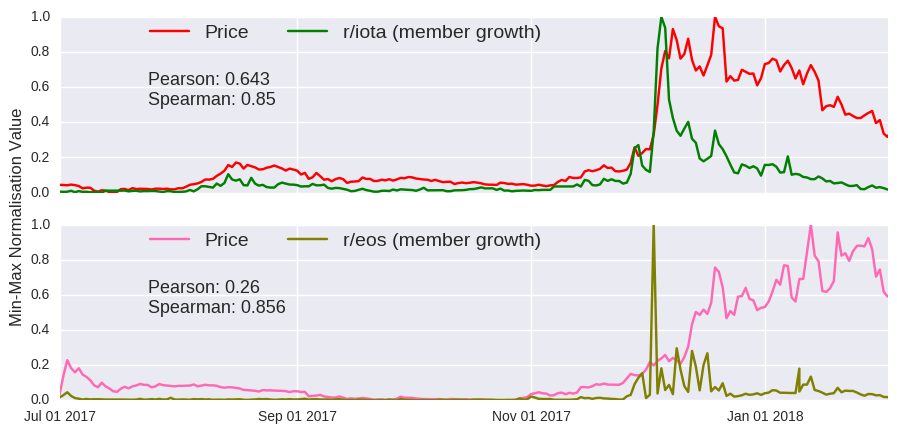

In [184]:
import matplotlib.dates as mdates

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 4.5))

for ax in [ax1, ax2]:
    ax.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017,2019)])

ax1.set_xticklabels([])
ax2.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') for i in range(1,13,2) for j in range(2017,2019)])
ax1.plot(iota_df['date'].astype(datetime.datetime),
         iota_df['close'], label='Price', color='r')
ax1.plot(iota_df['date'].astype(datetime.datetime),
         iota_df['subscriber_growth'], label='r/iota (member growth)', color='green')
ax2.plot(cardano_df['date'].astype(datetime.datetime),
         cardano_df['close'], label='Price', color='#FF69B4')
ax2.plot(cardano_df['date'].astype(datetime.datetime),
         cardano_df['subscriber_growth'], label='r/eos (member growth)', color='#808000')
for df,ax in zip([iota_df, cardano_df], [ax1, ax2]):
    ax.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})
    ax.set_xlim([datetime.date(2017, 7, 1), datetime.date(2018, 2, 2)])
    ax.text(x=mdates.date2num(datetime.date(2017, 7, 24)), y=0.5, fontsize=13,
         s='Pearson: {}\nSpearman: {}'.format(
        round(df['close'].corr(df['subscriber_growth'],method='pearson'),3), 
        round(df['close'].corr(df['subscriber_growth'],method='spearman'),3)))
fig.text(0.005, 0.5, 'Min-Max Normalisation Value', va='center', rotation='vertical',fontsize=12)
plt.tight_layout()
plt.savefig("crypto_reddit_price.png")
plt.show()

Visually speaking, there's clearly some correlation between price and subreddit member growth (the y-axis was normalised using the conventional [min-max scaling](https://stats.stackexchange.com/questions/70801/how-to-normalize-data-to-0-1-range)). While the Spearman rank correlation is similarly high for both coins, the Pearson correlation coefficient is significantly stronger for iota, highlighting the importance of not relying on one single measure. At the time of writing, iota and eos both had a marketcap of about \$5bn (11th and 9th  overall), though the number of subscribers to the iota subreddit was over 3 times more than the eos subreddit (105k and 30k, respectively). While this doesn't establish whether the relationship between price and reddit is predictive or reactive, it does suggest that reddit metrics could be useful model features for some coins.

### Google Trends

You'll notice an almost simultaneous spike in suscribers to the iota and eos subreddits in late November and early December. This was part of a wider crypto trend, where most coins experienced unprecendented gains. Leading the charge was Bitcoin, which tripled in price between November 15th and December 15th. As the most well known crypto to nocoiners, Bitcoin (and the wider blockchain industry) received considerable [mainstream attention](https://www.theguardian.com/business/live/2017/dec/07/pound-sterling-ftse-brexit-bitcoin-economics-business-live) during this bull run. Presumably, this attracted quite alot of new crypto investors (i.e [gamblers](https://www.cnbc.com/2017/12/11/people-are-taking-out-mortgages-to-buy-bitcoin-says-joseph-borg.html)), which propelled the price even higher. Well, what's the first thing you're [gonna do](https://www.youtube.com/watch?v=tpD00Q4N6Jk) after [reading an article about this fancy futuristic blockchain that's making people rich](https://www.nytimes.com/2018/01/13/style/bitcoin-millionaires.html)?. You'd google bitcoin, ethereum and obviously [bitconnect](https://www.youtube.com/watch?v=21kGmCsJ5ZM).

With `cryptory`, you can easily combine conventional crypto metrics with [Google Trends](https://trends.google.com/trends/) data. You just need to decide the terms you want to search. It's basically a small wrapper on top of the [pytrends](https://github.com/GeneralMills/pytrends) package. If you've used [Google Trends](https://trends.google.com/trends/) before, you'll be aware that you can only retrieve daily scores for max 90 day periods. The `get_google_trends` method stitches together overlapping searches, so that you can pull daily scores going back years. It's probably best to illustrate it with a few examples.

In [100]:
my_cryptory.get_google_trends(kw_list=['bitcoin'])

,date,bitcoin
0,2018-02-09,22.000000
1,2018-02-08,25.000000
2,2018-02-07,30.000000
...,...,...
402,2017-01-03,3.974689
403,2017-01-02,4.377918
404,2017-01-01,2.707397


Now we can investigate the relationship between crypto price and google search popularity.

In [101]:
btc_google = my_cryptory.get_google_trends(kw_list=['bitcoin']).merge(
    my_cryptory.extract_coinmarketcap('bitcoin')[['date','close']], on='date', how='inner')

eth_google = my_cryptory.get_google_trends(kw_list=['ethereum']).merge(
    my_cryptory.extract_coinmarketcap('ethereum')[['date','close']], on='date', how='inner')

verge_google = my_cryptory.get_google_trends(kw_list=['verge']).merge(
    my_cryptory.extract_coinmarketcap('verge')[['date','close']], on='date', how='inner')

In [102]:
for df,search_term in zip([btc_google, eth_google, verge_google], 
                          ['bitcoin', 'ethereum', 'verge']):
    df[[search_term,'close']] = (
        df[[search_term, 'close']]-df[[search_term, 'close']].min())/(
        df[[search_term, 'close']].max()-df[[search_term, 'close']].min())

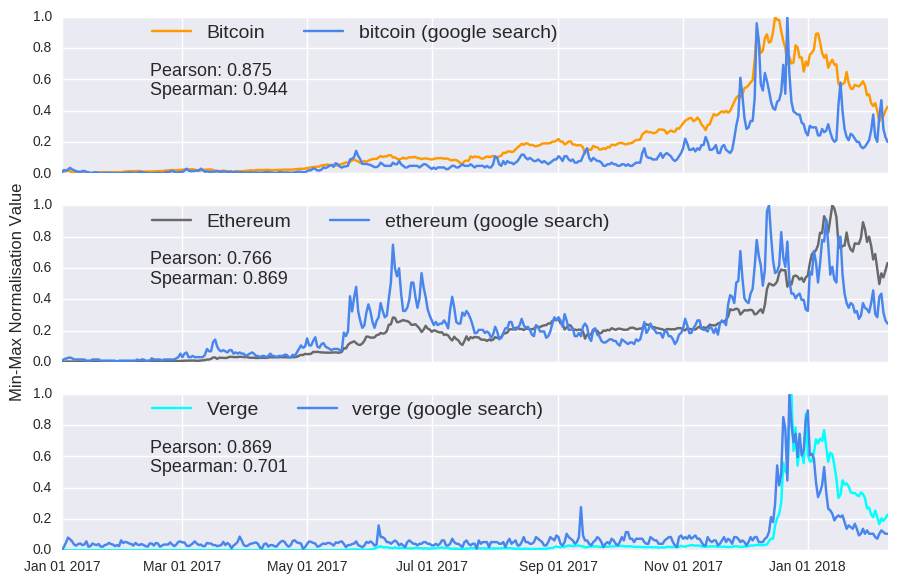

In [103]:
import matplotlib.dates as mdates

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 6))

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017,2019)])

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') for i in range(1,13,2) for j in range(2017,2019)])
for ax,df,search_term, coin, pcol, gcol in zip([ax1, ax2, ax3],[btc_google, eth_google, verge_google], 
                                               ['bitcoin', 'ethereum', 'verge'],
                                               ['Bitcoin', 'Ethereum', 'Verge'], 
                                               ['#FF9900', '#696969', '#00FFFF'],
                                               ['#4885ed', '#4885ed', '#4885ed']):
    ax.plot(df['date'].astype(datetime.datetime),
             df['close'], label=coin, color=pcol)
    ax.plot(df['date'].astype(datetime.datetime),
             df[search_term], label="{} (google search)".format(search_term), color=gcol)
    ax.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})
    ax.text(x=mdates.date2num(datetime.date(2017, 2, 13)), y=0.5, fontsize=13,
         s='Pearson: {}\nSpearman: {}'.format(
        round(df['close'].corr(df[search_term],method='pearson'),3), 
        round(df['close'].corr(df[search_term],method='spearman'),3)))
fig.text(0.005, 0.5, 'Min-Max Normalisation Value', va='center', rotation='vertical',fontsize=12)
plt.tight_layout()
plt.show()

As before, it's visually obvious and statisically clear that there's a strong correlation between google searches and coin prices. Again, this a well known observation ([here](http://uk.businessinsider.com/bitcoin-price-correlation-google-search-2017-9), [here](https://www.express.co.uk/finance/city/911979/Cryptocurrency-Google-search-bitcoin-boom-ethereum-price-warning-boost) and [here](https://www.reddit.com/r/dataisbeautiful/duplicates/7ldxy7/2017_bitcoin_value_versus_google_search_interest/)). What's not so apparent is whether google search drives or follows the price. That chicken and egg question question will be addressed in my next deep learning post. 

A few words on Verge (xvg): eccentric (i.e. [crazy](http://uk.businessinsider.com/the-crazy-life-of-john-mcafee)) crypto visionary [John McAfee](https://twitter.com/officialmcafee?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor) [recommended](https://twitter.com/officialmcafee/status/941003398215761922?lang=en) (i.e. [shilled](https://twitter.com/officialmcafee/status/946052577539579906)) the unheralded Verge to his twitter followers (i.e. fools), which triggered a huge surge in its price. As is usually the case with pump and dumps, the pump (from which [McAfee himself potentially profitted](https://www.financemagnates.com/cryptocurrency/news/john-mcafee-pumping-cryptocurrencies-cash/)) was followed by the dump. The sorry story is retold in both the price and google search popularity. Unlike bitcoin and ethereum though, you'd need to consider in your analysis that verge is also a common search term for popular online technology news site [The Verge](https://www.theverge.com/) ([tron](https://en.wikipedia.org/wiki/Tron) would be a similar case). 

Anyway, back to `cryptory`, you can supply more than one keyword at a time, allowing you to visualise the relative popularity of different terms. Let's go back to the early days and compare the historical popularity of Kim Kardashian and Bitcoin since 2013.

In [104]:
long_cryptory = Cryptory(from_date="2013-01-01")

kim_btc_df = long_cryptory.get_google_trends(kw_list=['kim kardashian','bitcoin'])
kim_btc_df

,date,kim kardashian,bitcoin
0,2018-02-09,3.013603,13.259854
1,2018-02-08,2.410883,15.068016
2,2018-02-07,3.013603,18.081619
...,...,...,...
1863,2013-01-03,11.875022,0.466900
1864,2013-01-02,13.062524,0.000000
1865,2013-01-01,17.812533,0.000000


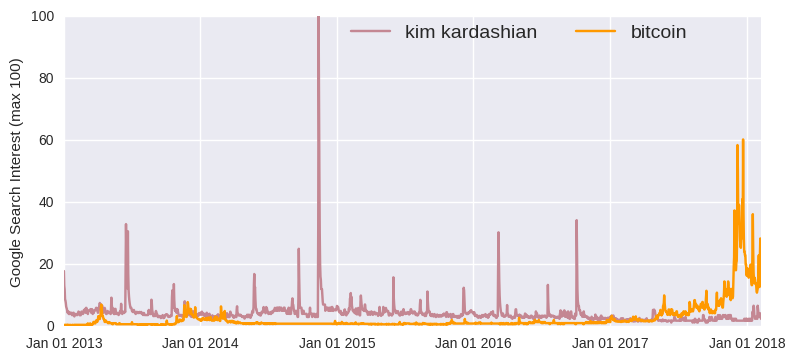

In [105]:
fig, ax1 = plt.subplots(1, 1, figsize=(9, 4))

ax1.set_xticks([datetime.date(j,1,1) for j in range(2013,2019)])
ax1.set_xticklabels([datetime.date(j,1,1).strftime('%b %d %Y') for j in range(2013,2019)])
for search_term, col in zip(['kim kardashian', 'bitcoin'], ('#C48793', '#FF9900')):
    ax1.plot(kim_btc_df['date'].astype(datetime.datetime), 
             kim_btc_df[search_term], label=search_term, color=col)
ax1.set_ylabel('Google Search Interest (max 100)')    
ax1.legend(bbox_to_anchor=(0.4, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})
plt.show()

According to Google Trends, bitcoin became a more popular search term in June 2018 (a sure sign of a bubble if ever there was one- [just realised this isn't a unique insight either](http://uk.businessinsider.com/bitcoin-passes-beyonc-taylor-swift-and-kim-kardashians-popularity-2017-12?r=US&IR=T)). That said, Bitcoin has never reached the heights of Kim Kardashian on the 13th November 2014 (obviously, the day [Kim Kardashian broke the internet](https://www.theguardian.com/lifeandstyle/2014/dec/17/kim-kardashian-butt-break-the-internet-paper-magazine)).  The graph shows daily values, but you'll notice that it quite closely matches what you'd get for [the same weekly search on the Google Trends website](https://trends.google.com/trends/explore?date=2013-01-01%202018-02-03&q=kim%20kardashian,bitcoin).

While social metrics like reddit and google popularity can be powerful tools to study cryptocurrency prices, you may also want to incorporate data related to finance and the wider global economy.

### Stock Market Prices

With their market caps and closing prices, cryptocurrencies somewhat resemble traditional company stocks. Of course, the major difference is that you couldn't possibly pay for a lambo by investing in the stock market. Still, looking at the stock market may provide clues as to how the general economy is performing, or even how specific industries are responding to the blockchain revolution.

`cryptory` includes a `get_stock_prices` method, which scrapes yahoo finance and returns historical daily data. Just note that you'll need to find the relevant company/index code on the yahoo finance website.

In [106]:
# %5EDJI = Dow Jones
my_cryptory.get_stock_prices("%5EDJI")

,date,adjclose,close,high,low,open,volume
0,2018-02-10,24190.900391,24190.900391,24382.140625,23360.289062,23992.669922,735030000.0
1,2018-02-09,24190.900391,24190.900391,24382.140625,23360.289062,23992.669922,735030000.0
2,2018-02-08,23860.460938,23860.460938,24903.679688,23849.230469,24902.300781,657500000.0
...,...,...,...,...,...,...,...
403,2017-01-03,19881.759766,19881.759766,19938.529297,19775.929688,19872.859375,339180000.0
404,2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN
405,2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN


You may notice the previous closing prices are carried over on days the stock market is closed (e.g. weekends). You can choose to turn off this feature when you initialise your cryptory class (see `help(Cryptort.__init__)`).

With a little help from pandas, we can visualise the performance of bitcoin relative to some specific stocks and [indices](http://business.nasdaq.com/marketinsite/2016/Indexes-or-Indices-Whats-the-deal.html).

In [107]:
stocks_df = my_cryptory.extract_coinmarketcap("bitcoin")[['date', 'close']].rename(
            {'close':'Bitcoin'}, axis=1)
stock_codes = ['%5EDJI', 'AMD', 'NVDA', 'AMZN', 'GOOG', '%5EIXIC', 'JPM', 'INTC', 'KODK']
stock_names = ['Dow Jones', 'AMD', 'NVIDIA', 'Amazon', 'Google', 'Nasdaq', 'JP Morgan', 'Intel', 'Kodak']
for stock_code, stock_name in zip(stock_codes, stock_names):
    stocks_df = stocks_df.merge(
        my_cryptory.get_stock_prices(stock_code)[['date', 'close']].rename(
            {'close':stock_name}, axis=1), on='date', how='inner')
stocks_df = stocks_df.dropna(axis=0, how='any')

for col in stocks_df.columns:
    if col != 'date':
        stocks_df[col] = stocks_df[col]/stocks_df[col][-1:].values

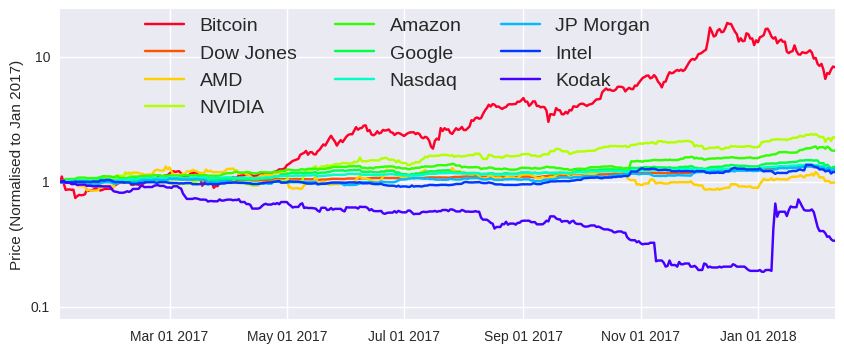

In [108]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))

cm = plt.get_cmap('gist_rainbow')

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017, 2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') 
                     for i in range(1,13,2) for j in range(2017, 2019)])
for stock_name, color in zip([col for col in stocks_df.columns if col != 'date'],
                             [cm(1.*i/len(stocks_df.columns)) for i in range(len(stocks_df.columns))]):
    ax1.plot(stocks_df['date'].astype(datetime.datetime), 
             stocks_df[stock_name], label=stock_name, color=color)
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: (
            '{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.set_ylabel('Price (Normalised to Jan 2017)')
ax1.set_ylim([0.08, 24])
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., ncol=3, prop={'size': 14})
plt.show()

This graph shows the return you would have received if you had invested on January 3rd. As Bitcoin went up the most (>10x returns), it was objectively the best investment. While the inclusion of some names is hopefully intuitive enough, AMD and NVIDIA (and Intel to some extent) are special cases, as these companies produce the [graphics cards](http://www.techradar.com/news/best-mining-gpu) that underpin the hugely energy intensive (i.e. [wasteful](https://www.theguardian.com/technology/2018/jan/17/bitcoin-electricity-usage-huge-climate-cryptocurrency)) process of [crypto mining](https://news.bitcoin.com/a-visit-to-a-bitcoin-mining-farm-in-sichuan-china-reveals-troubles-beyond-regulation/). Kodak (not to be confused with the pre 2012 bankruptcy Kodak) made the list, as they announced their intention in early Jan 2018 to [create their own "photo-centric cryptocurrency"](https://www.nytimes.com/2018/01/30/technology/kodak-blockchain-bitcoin.html) (yes, that's what caused that blip).

As before, with a little bit of pandas work, you can create a bitcoin stock market correlation plot.

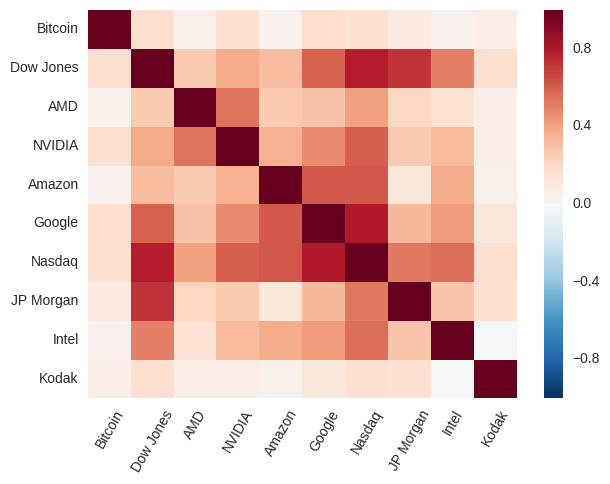

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

# remove non-trading days from correlation analysis
plt.figure(figsize=(6.5, 5))
corr = Cryptory(from_date="2017-01-01", fillgaps=False).get_stock_prices('%5EDJI').dropna()[['date']].merge(
    stocks_df, on = 'date', how='inner').drop(labels='date', axis=1).pct_change().corr(method='pearson')
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values,
            vmin=-1,  vmax=1)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

The highest correlation recorded (0.75) is between Google and Nasdaq, which is not surprising, as the former is large component of the latter. As for Bitcoin, it was most correlated with Google (0.12), but its relationship with the stock market was generally quite weak.

### Commodity Prices

While Bitcoin was originally envisioned as alternative system of payments, [high transaction fees and rising value has discouraged its use as a legitimate currency](https://hackernoon.com/ten-years-in-nobody-has-come-up-with-a-use-case-for-blockchain-ee98c180100). This has meant that Bitcoin and its successors have morphed into an alternative store of value- a sort of [easily lost](http://uk.businessinsider.com/nearly-4-million-bitcoins-have-been-lost-forever-study-says-2017-11) internet gold. So, it may be interesting to investigate the relationship between Bitcoin and the more traditional stores of value.

`cryptory` includes a `get_metal_prices` method that retrieves historical daily prices of various precious metals.

In [110]:
my_cryptory.get_metal_prices()

,date,gold_am,gold_pm,silver,platinum_am,platinum_pm,palladium_am,palladium_pm
0,2018-02-10,1316.05,1314.10,16.345,972.0,969.0,970.0,969.0
1,2018-02-09,1316.05,1314.10,16.345,972.0,969.0,970.0,969.0
2,2018-02-08,1311.05,1315.45,16.345,974.0,975.0,990.0,985.0
...,...,...,...,...,...,...,...,...
403,2017-01-03,1148.65,1151.00,15.950,906.0,929.0,684.0,706.0
404,2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405,2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Again, we can easily plot the change in commodity over 2017 and 2018.

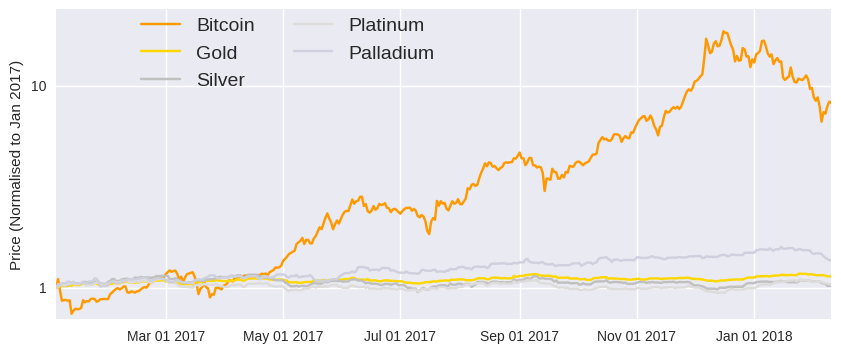

In [111]:
metals_df = my_cryptory.get_metal_prices().dropna().merge(
 my_cryptory.extract_coinmarketcap('bitcoin')[['date', 'close']], on='date', how='inner')

for col in metals_df.columns:
    if col != 'date':
        metals_df[col] = metals_df[col]/metals_df[col][-1:].values

fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017, 2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') 
                     for i in range(1,13,2) for j in range(2017, 2019)])
for col, col_label, color in zip(['close', 'gold_pm', 'silver', 'platinum_pm', 'palladium_pm'],
                          ['Bitcoin', 'Gold', 'Silver', 'Platinum', 'Palladium'],
                          ['#FF9900', '#FFD700', '#C0C0C0', '#dedcda', '#CED0DD']):
    ax1.plot(metals_df['date'].astype(datetime.datetime), 
             metals_df[col], label=col_label, color=color)
ax1.set_yscale('log')
ax1.set_ylim([0.7, 24])
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: (
            '{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.set_ylabel('Price (Normalised to Jan 2017)')
plt.show()

Look at silly old gold slowly and consistently appreciating over 2017 and 2018, thus representing a [stable store of wealth](https://www.bullionvault.com/gold-guide/why-gold). As before, we can plot a price correlation matrix.

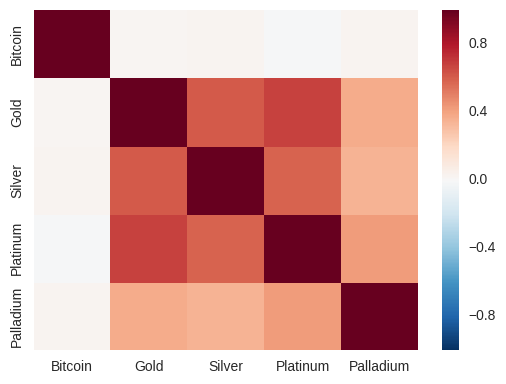

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

# remove non-trading days from correlation analysis
corr = Cryptory(from_date="2017-01-01", fillgaps=False).get_stock_prices('%5EDJI').dropna()[['date']].merge(
    metals_df, on = 'date', how='inner')[[
        'close', 'gold_pm', 'silver', 'platinum_pm', 'palladium_pm']].pct_change().corr(method='pearson')
plt.figure(figsize=(5.4, 4))
sns.heatmap(corr, xticklabels=['Bitcoin', 'Gold', 'Silver', 'Platinum', 'Palladium'], 
                 yticklabels=['Bitcoin', 'Gold', 'Silver', 'Platinum', 'Palladium'],
           vmin=-1, vmax=1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Unsurprisingly, the various precious metals exhibit significant correlation, while bitcoin value appears completely unconnected. I suppose negative correlation could have provided evidence that people are moving away from traditional stores of value, but there's little evidence to support this theory.

### Foreign Exchange Rates

One of the motivations behind Bitcoin was to create a currency that wasn't controlled by any central authority. There could be no [quantitative easing](https://en.wikipedia.org/wiki/Quantitative_easing)- when the US Central Bank devalued the dollar by essentially printing trillions of new dollars to prop up the faltering economy after the 2007 financial crisis. As such, there may be a relationship between USD exchange rate (which would be devalued by such policies) and money moving into cryptocurrencies.

`cryptory` includes a `get_exchange_rates` method that retrieves historical daily exchange rate between particular currency pairs.

In [113]:
my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")

,date,exch_rate
0,2018-02-10,1.2273
1,2018-02-09,1.2273
2,2018-02-08,1.2252
...,...,...
403,2017-01-03,1.0385
404,2017-01-02,NaN
405,2017-01-01,NaN


As you can see, the USD has lost ground to the Euro over the last year. We can easily add a few more USD exchange rates (spoiler alert:the USD has depreciated relative to most major currencies). As the results are similar to the precious metals, that code can be found in the [Jupyter notebook](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2018-02-11-analysing-the-factors-that-influence-cryptocurrency-prices-with-cryptory.ipynb).

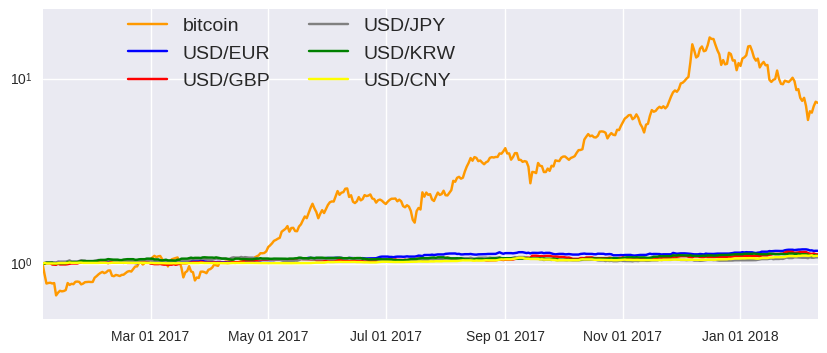

In [114]:
exchange_df = my_cryptory.extract_coinmarketcap("bitcoin")[['date','close']].rename(
    {'close':'bitcoin'}, axis=1)
my_currencies = ['EUR', 'GBP', 'JPY', 'KRW', 'CNY']
for curr in my_currencies:
    exchange_df = exchange_df.merge(
        my_cryptory.get_exchange_rates(from_currency='USD', to_currency=curr).rename(
    {'exch_rate':'USD_'+curr}, axis=1), on='date', how='inner')
exchange_df = exchange_df.dropna()

for col in exchange_df.columns:
    if col != 'date':
        exchange_df[col] = exchange_df[col]/exchange_df[col][-1:].values

fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017, 2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') 
                     for i in range(1,13,2) for j in range(2017, 2019)])
for col, colour in zip([col for col in exchange_df.columns if col != 'date'],
                       ['#FF9900', 'blue', 'red', 'gray', 'green', 'yellow']):
    ax1.plot(exchange_df['date'].astype(datetime.datetime),
             exchange_df[col], label=col.replace("_", "/"), color=colour)
ax1.set_yscale('log')
ax1.set_ylim([0.5, 24])
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})
plt.show()

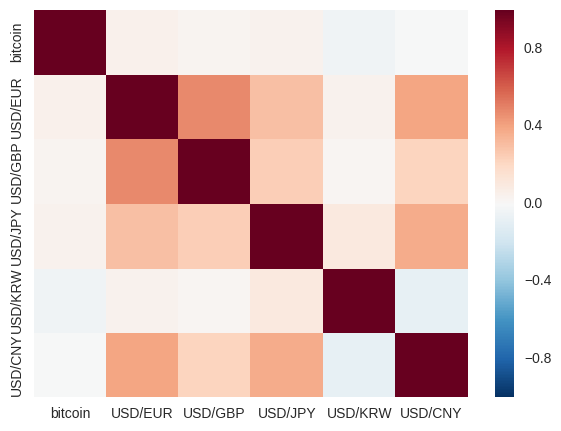

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

# remove non-trading days from correlation analysis
corr = Cryptory(from_date="2017-01-01", fillgaps=False).get_exchange_rates(
    from_currency='USD', to_currency='EUR').dropna()[['date']].merge(
    exchange_df, on = 'date', how='inner').drop('date', axis=1).pct_change().corr(method='pearson')
plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(corr, xticklabels=[col.replace("_", "/") for col in corr.columns], 
             yticklabels=[col.replace("_", "/") for col in corr.columns])
plt.xticks(rotation=0)
plt.show()

There are some geographical relationships here- USD/GBP and USD/EUR are most strongly correlated- but there's little evidence of a connection between Bitcoin price and USD exchange rates.

### Oil Prices

Oil prices are strongly affected by the strength of the global economy (e.g. demand in China) and geopolitical instability (e.g. Middle East, Venezuela). Of course, there's other factors at play (shale, moves towards renewables, etc.), but you might want to have oil prices in your crypto price model in order to include these forces.

`cryptory` includes a `get_oil_prices` method that retrieves historical daily oil ([London Brent Crude](https://en.wikipedia.org/wiki/Brent_Crude)) prices.

In [116]:
my_cryptory.get_oil_prices()

,date,oil_price
0,2018-02-10,64.18
1,2018-02-09,64.18
2,2018-02-08,64.18
...,...,...
403,2017-01-03,52.36
404,2017-01-02,NaN
405,2017-01-01,NaN


As you can see, oil is up about 20% since the start of 2017. Of course, you can plot the price over a longer time period.

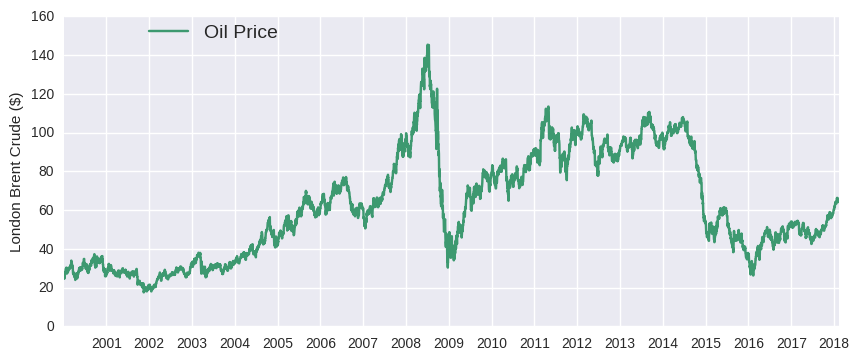

In [134]:
oil_df = Cryptory(from_date="2000-01-01").get_oil_prices()

fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))
ax1.set_xticks([datetime.date(j,1,1) for j in range(2000,2019)])
ax1.set_xticklabels([datetime.date(j,1,1).strftime('%Y') for j in range(2000,2019)])
ax1.plot(oil_df['date'].astype(datetime.datetime),
         oil_df['oil_price'], label='Oil Price', color='#3D9970')
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})
ax1.set_ylabel('London Brent Crude ($)')
plt.show()

## Future

So what's the future of cryptos? Moon, obviously! As for the future of [cryptory](https://github.com/dashee87/cryptory), it already includes numerous tools that could improve price models (particularly, reddit and google trend metrics). But it's certainly lacking features that would take it to the moon: 
-  twitter statistics (specifically John McAffee's!!!) 
-  media analysis (number of mainstream articles, sentiment, etc.- [example](https://github.com/mattlisiv/newsapi-python))
-  more Asian-centric data sources (Japan and South Korea are said to account for [40%](https://www.ft.com/content/384936ac-e70c-11e7-97e2-916d4fbac0da) and [20%](http://www.straitstimes.com/asia/south-korean-officials-grapple-with-bitcoin-mania) of global bitcoin volume, respectively)
- more financial/crypto data (integrate [Quandl api](https://www.quandl.com/tools/python))

In my next post, I'll use [cryptory](https://github.com/dashee87/cryptory) to (hopefully) improve the [previous LSTM crypto price prediction model](https://dashee87.github.io/deep%20learning/python/predicting-cryptocurrency-prices-with-deep-learning/). While you wait for that, you can perform your own cryptocurrency analysis with the [accompanying Jupyter notebook](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2018-02-11-analysing-the-factors-that-influence-cryptocurrency-prices-with-cryptory.ipynb). Thanks for reading!